## A/B тест

Проанализируем результаты эксперимента, который мы провели вместе с командой дата сайентистов. Эксперимент проходил с 2023-07-30 по 2023-08-05 включительно. Для эксперимента были задействованы 2 и 1 группы.    
В группе 2 был использован один из новых алгоритмов рекомендации постов, группа 1 использовалась в качестве контроля. 
Основная гипотеза заключается в том, что новый алгоритм во 2-й группе приведет к увеличению CTR.    
Нужно проанализировать данные А/B-теста. 

In [1]:
import pandahouse
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import hashlib #делать хеши
import swifter #ускорялка
from scipy import stats
%matplotlib inline

In [2]:
#подключаемся к схеме данных
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'database':'simulator_20230820',
    'user':'student',
    'password':'dpo_python_2020'
}

q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM simulator_20230820.feed_actions 
WHERE toDate(time) between '2023-07-30' and '2023-08-05'
    and exp_group in (1,2)
GROUP BY exp_group, user_id
"""

df = pandahouse.read_clickhouse(q, connection=connection)

In [3]:
df.head(10)

,exp_group,user_id,likes,views,ctr
0,1,109963,3,15,0.200000
1,1,26117,32,141,0.226950
2,1,138232,18,73,0.246575
3,1,18392,7,32,0.218750
4,1,26295,39,141,0.276596
5,2,131473,9,108,0.083333
6,2,23985,7,87,0.080460
7,2,24523,11,101,0.108911
8,2,32420,13,44,0.295455
9,2,24239,40,90,0.444444


In [4]:
df.groupby('exp_group')['user_id'].nunique()

exp_group
1    10020
2     9877
Name: user_id, dtype: int64

__1. Выбрать метод анализа и сравнить CTR в двух группах ( t-тест, Пуассоновский бутстреп, тест Манна-Уитни, t-тест на сглаженном ctr (α=5), а также t-тест и тест Манна-Уитни поверх бакетного преобразования).__      
__2. Сравните данные этими тестами. А еще посмотрите на распределения глазами. Почему тесты сработали именно так?__

In [5]:
#посмотрим значение p-value по T-тесту (Тест Стьюдента)
stats.ttest_ind(df[df.exp_group == 1].ctr,
                df[df.exp_group == 2].ctr,
                equal_var=False)

Ttest_indResult(statistic=0.4051491913112757, pvalue=0.685373331140751)

In [6]:
#посмотрим значене p-value по тесту Манна-Уитни
stats.mannwhitneyu(df[df.exp_group == 1].ctr, 
                   df[df.exp_group == 2].ctr,
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=55189913.0, pvalue=4.632205841806026e-45)

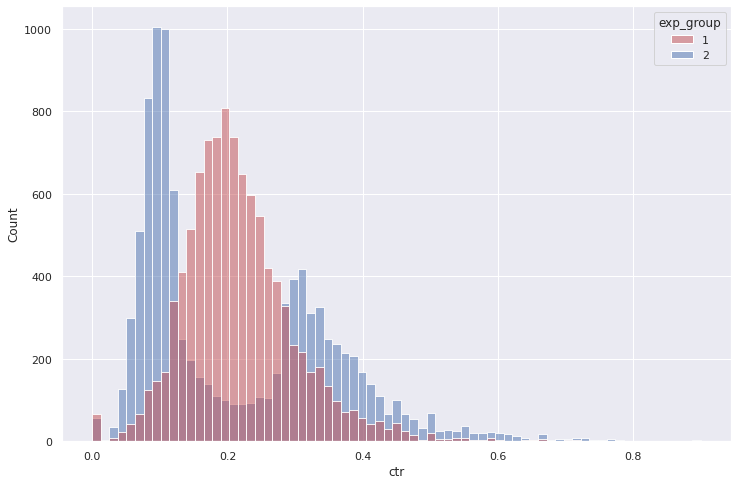

In [7]:
# Сделаем графики в seaborn
sns.set(rc={'figure.figsize':(12,8)})

groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

##### __Выводы по t-тесту и тесту Манна-Уитни.__   
При анализе A/B теста, мы видим, что распределение метрики в группе B бимодальное (двугорбое), а в группе A распределение выглядит более нормальным (одним пиком), это может указывать на наличие двух различных подгрупп пользователей в группе B.

Из-за двугорбого распределения в группе B результаты t-критерия Стьюдента могут быть менее надежными, и это может привести к некорректным выводам. Тест Манна-Уитни, с другой стороны, является непараметрическим тестом и менее чувствителен к форме распределения данных и выбросам. Поэтому, если есть данные с нестандартным распределением, тест Манна-Уитни может быть более подходящим выбором.

Таким образом, результаты теста Манна-Уитни указывают на наличие статистически значимых различий между группами или выборками, которые были сравнены. Значение pvalue=4.632205841806026e-45 очень близко к нулю (практически нулевое), что указывает на высокую степень статистической значимости.

#### __Сглаженный CTR__

In [8]:
def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr

In [9]:
# находим общегрупповой CTR
global_ctr_1 = df[df.exp_group == 1].likes.sum()/df[df.exp_group == 1].views.sum()
global_ctr_2 = df[df.exp_group == 2].likes.sum()/df[df.exp_group == 2].views.sum()

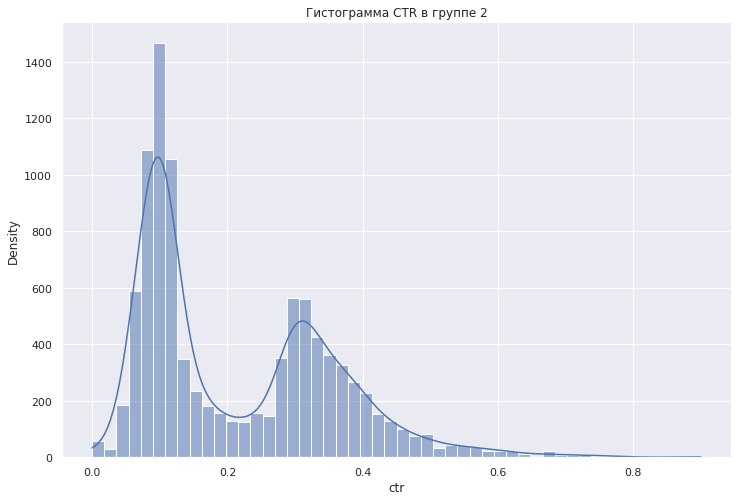

In [10]:
group2 = df[df.exp_group == 2].copy()
sns.histplot(group2.ctr, bins=50, kde=True)
plt.xlabel('ctr')
plt.ylabel('Density')
plt.title('Гистограмма CTR в группе 2')
plt.show()

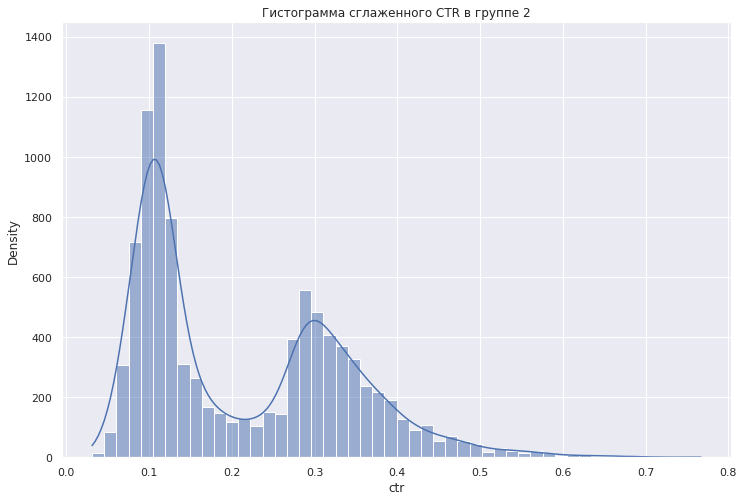

In [11]:
group2['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_2, 5), axis=1)

sns.histplot(group2.smothed_ctr, bins=50, kde=True)
plt.xlabel('ctr')
plt.ylabel('Density')
plt.title('Гистограмма сглаженного CTR в группе 2')
plt.show()

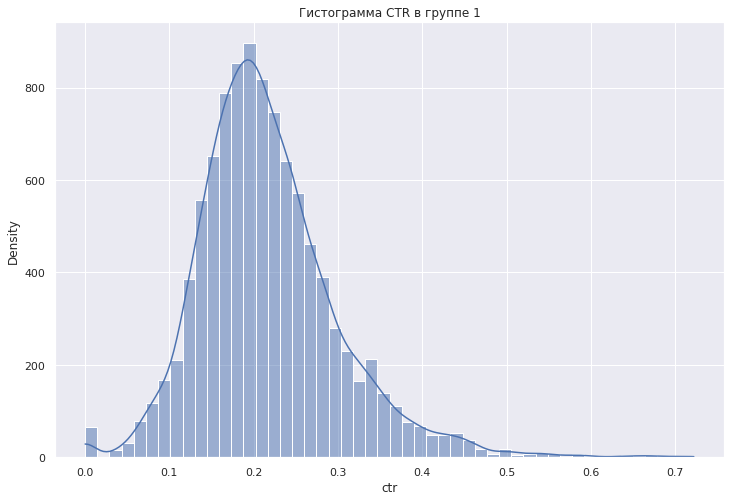

In [12]:
group1 = df[df.exp_group == 1].copy()
sns.histplot(group1.ctr, bins=50, kde=True)
plt.xlabel('ctr')
plt.ylabel('Density')
plt.title('Гистограмма CTR в группе 1')
plt.show()

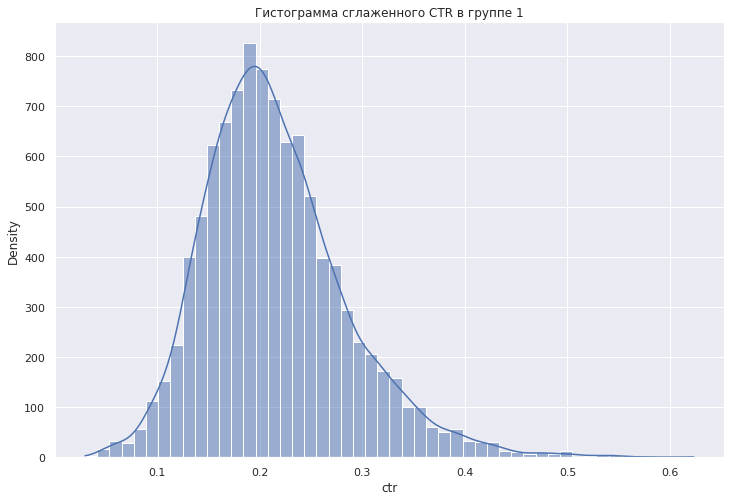

In [13]:
group1['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis=1)

sns.histplot(group1.smothed_ctr, bins=50, kde=True)
plt.xlabel('ctr')
plt.ylabel('Density')
plt.title('Гистограмма сглаженного CTR в группе 1')
plt.show()

In [14]:
#значение p value по тесту Манна-Уитни
stats.mannwhitneyu(group1['smothed_ctr'], 
                   group2['smothed_ctr'],
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=55528353.0, pvalue=2.396534039374286e-50)

In [15]:
#значение p value по t-тесту
stats.ttest_ind(group1['smothed_ctr'], 
                group2['smothed_ctr'],
                equal_var=False)

Ttest_indResult(statistic=1.9460491517027683, pvalue=0.05166679015318526)

##### __Выводы по сглаженному CTR:__      
Тест Манна-Уитни: p-value очень маленькое (близкое к нулю), что указывает на статистически значимое различие между группами.   
T-критерий Стьюдента: p-value равно примерно 0.052, что немного больше общепринятого уровня статистической значимости 0.05. Это говорит о том, что при использовании t-критерия Стьюдента различия между группами могут не быть статистически значимыми на уровне 0.05.   
Но, учитывая двугорбое распределение в группе B, рекомендуется придерживаться результатов теста Манна-Уитни и считать, что между группами существуют статистически значимые различия. В этом контексте результаты t-критерия Стьюдента могут быть менее надежными из-за нарушения предположения о нормальности распределения данных в группе B.

#### __Пуассоновский бутстреп для подсчета разницы в CTR__

In [16]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):

    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2

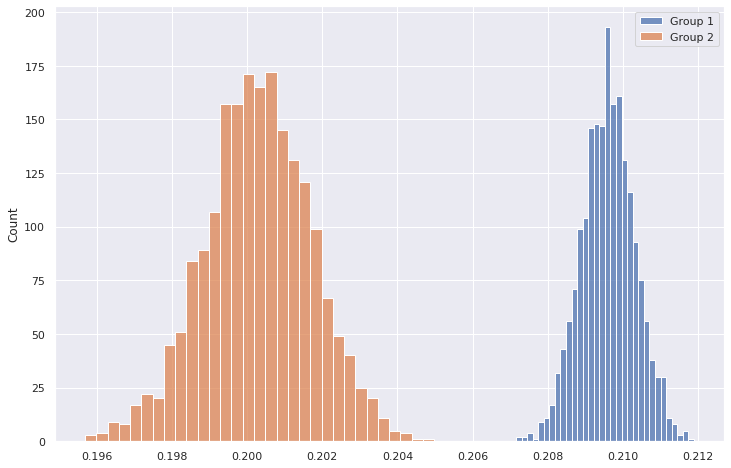

In [18]:
likes1 = df[df.exp_group == 1].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()
likes2 = df[df.exp_group == 2].likes.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()

ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

sns.histplot(ctr1, label='Group 1')
sns.histplot(ctr2, label='Group 2')
plt.legend()

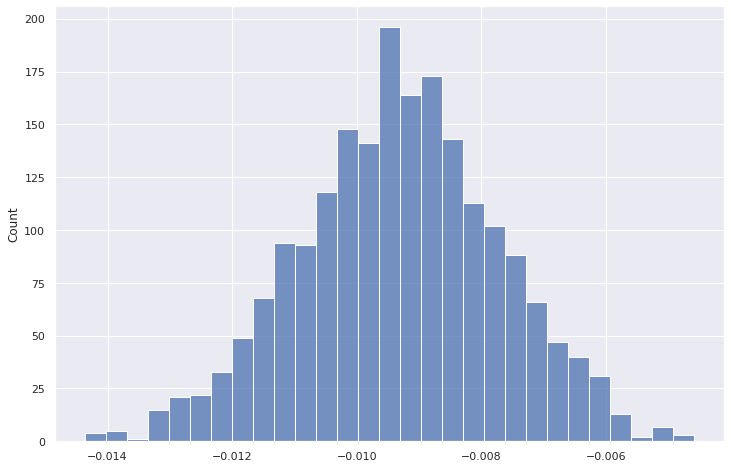

In [19]:
#Разница между глобальными CTR
sns.histplot(ctr2 - ctr1);

__Вывод:__ 
1. Отрицательное значение разницы указывает на то, что CTR во второй группе (ctr2) меньше, чем в первой группе (ctr1). Это может означать, что изменения, внесенные во вторую группу, могли отрицательно повлиять на кликабельность.   
2. Если разница в CTR (ctr2 - ctr1) не включает ноль внутри доверительного интервала, то это может указывать на статистически значимую разницу между двумя выборками. В данном контексте отсутствие нуля в доверительном интервале может означать, что разница не случайна и что выборки действительно отличаются статистически значимо

#### __Бакетное преобразование__

In [20]:
#Поверх бакетного преобразования можно применить тест Манна-Уитни.
q = """

SELECT exp_group, bucket,
    sum(likes)/sum(views) as bucket_ctr,
    quantileExact(0.9)(ctr) as ctr9
FROM (SELECT exp_group, 
        xxHash64(user_id)%50 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM {db}.feed_actions 
    WHERE toDate(time) between '2023-07-30' and '2023-08-05'
        and exp_group in (1,2)
    GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
"""

df = pandahouse.read_clickhouse(q, connection=connection)

#тест Манна-Уитни видит отличие
stats.mannwhitneyu(df[df.exp_group == 1].bucket_ctr, 
                   df[df.exp_group == 2].bucket_ctr, 
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=1997.0, pvalue=2.6576427804010095e-07)

In [21]:
#t-тест тоже
stats.ttest_ind(df[df.exp_group == 1].bucket_ctr, 
                df[df.exp_group == 2].bucket_ctr, 
                equal_var = False)

Ttest_indResult(statistic=5.614819358149381, pvalue=4.592644937473873e-07)

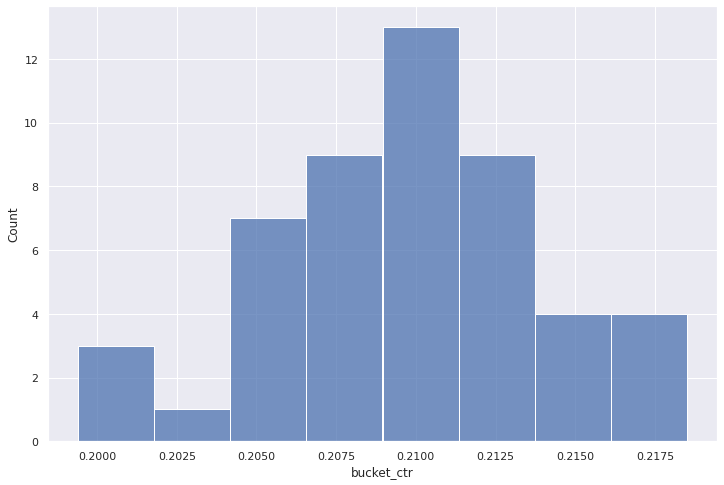

In [22]:
sns.histplot(df[df.exp_group == 1].bucket_ctr);

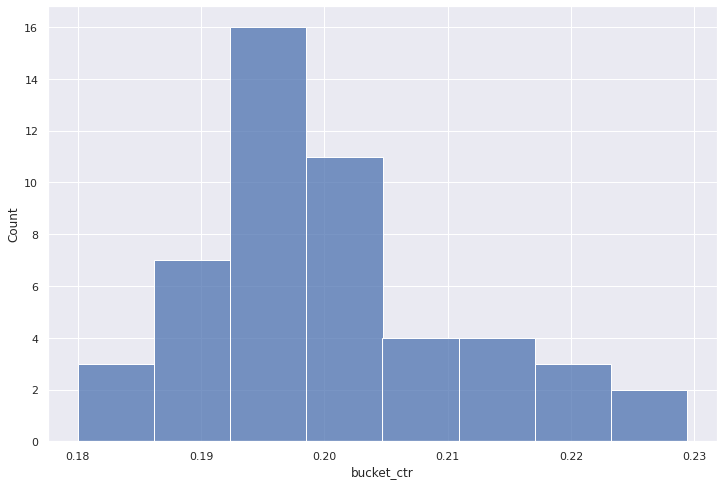

In [23]:
sns.histplot(df[df.exp_group == 2].bucket_ctr);

Распределение статистики внутри бакета +- похоже на нормальное

Посчитаем статистику 90% квантиль нашего CTR

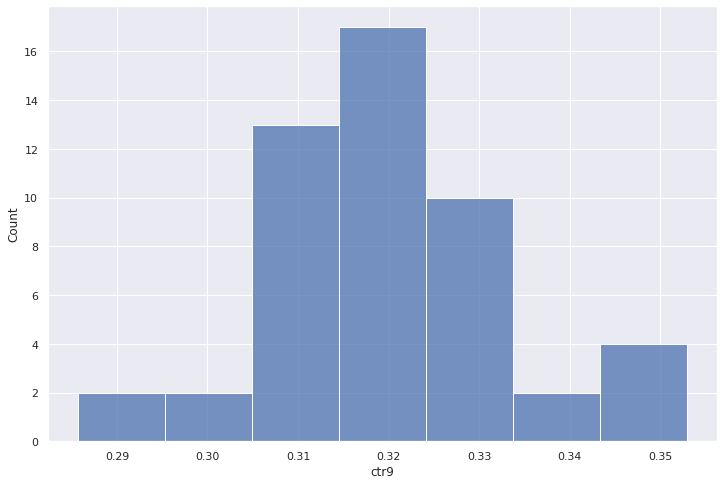

In [24]:
sns.histplot(df[df.exp_group == 1].ctr9);

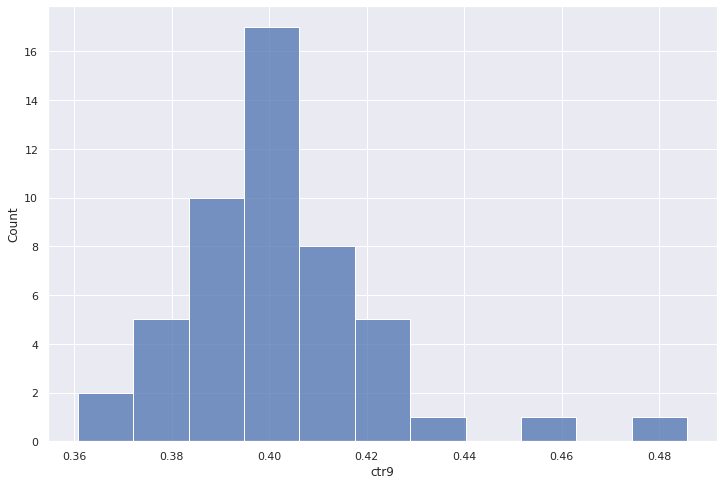

In [25]:
sns.histplot(df[df.exp_group == 2].ctr9);

In [26]:
#тест Манна-Уитни видит отличие
stats.mannwhitneyu(df[df.exp_group == 1].ctr9, 
                   df[df.exp_group == 2].ctr9, 
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=0.0, pvalue=6.7601631082665925e-18)

__Вывод:__ 
1. В t-тесте и тесте Манна-Уитни поверх бакетного преобразования p-value очень маленькое (близкое к нулю), и таким образом подтверждается статистически значимое различие между группой 1 и группой 2.
2. С помощью теста Манна-Уитни поверх бакетного преобразования так же подтверждается статистически значимое различие между 90% квантилем в группе 1 и 90% квантилем в группе 2

__3. Опишите потенциальную ситуацию, когда такое изменение могло произойти. Тут нет идеального ответа, подумайте.__

Отрицательное значение разницы указывает на то, что CTR во второй группе (ctr2) меньше, чем в первой группе (ctr1). Это может означать, что изменения, внесенные во вторую группу, могли отрицательно повлиять на кликабельность.
1. Алгоритм не учел интересы и предпочтения пользователей в этой группе, что привело к низкой кликабельности.
2. Новый алгоритм мог предлагать контент, который оказался менее релевантным для пользователей в группе 2. Это могло уменьшить интерес пользователей и, как следствие, CTR.
3. В период проведения эксперимента были сезонные изменения в поведении пользователей (например: летний отпуск), когда пользователи обычно менее активны, и это могло также повлиять на CTR. 
4. Технические сбои или проблемы

__4. Напишите рекомендацию, будем ли мы раскатывать новый алгоритм на всех новых пользователей или все-таки не стоит.__

Решение о том, следует ли раскатывать новый алгоритм на всех новых пользователей, или нет, зависит от нескольких факторов:
1. Проведенный А/B-тест показал, что новый алгоритм в группе 2 привел к снижению CTR по сравнению с группой 1. Это является значимым результатом и говорит о том, что новый алгоритм, возможно, не так эффективен, как ожидалось.
2. Помимо статистической значимости, необходимо оценить практическую значимость изменений. То есть, насколько снижение CTR влияет на бизнес-показатели.
3. Важно учитывать обратную связь пользователей

Если статистическая значимость снижения CTR важнее, и практическая значимость также негативно влияет на бизнес, то может быть разумнее не раскатывать новый алгоритм на всех новых пользователей.
Но, так же есть способы улучшить новый алгоритм, и обратная связь пользователей подтверждает потребность в этих улучшениях, то можно попробовать внести коррекции и провести повторное тестирование.